In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os

C:\Users\10709151\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量
results = {}

# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## 首先我們使用一般的 DNN (MLP) 來訓練
由於 DNN 只能輸入一維的資料，我們要先將影像進行攤平，若 (50000, 32, 32, 3) 的影像，攤平後會變成 (50000, 32*32*3) = (50000, 3072)

In [3]:
# 將資料攤平成一維資料
x_train = x_train.reshape(50000, 3072) 
x_test = x_test.reshape(10000, 3072)

# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [4]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(3072,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

exp_name_tag = 'DNN-0'
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 1,841,162
Trainable params: 1,841,162
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s 83us/step - loss: 2.1

## 接下來我們使用 CNN 來訓練神經網路
CNN 的原理非常適合處理影像類的資料，就讓我們來看看，同樣的訓練條件，CNN 是否顯著優於 DNN 呢?

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

exp_name_tag = 'CNN-0'
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

## 同樣運算 10 個 epochs，但 CNN 在 test data 的準確率顯著優於 DNN!

## 作業
1. 請試著調整各個超參數，並說明那些超參數對於結果有明顯的影響?
2. CNN 與 DNN 哪個模型的參數數量比較多? 造成參數的數量不同的原因在哪?

In [7]:
batch_size = 256 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

#### DNN 256,10,10

In [8]:
# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# 將資料攤平成一維資料
x_train = x_train.reshape(50000, 3072) 
x_test = x_test.reshape(10000, 3072)

# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

model_dnn1 = Sequential()
model_dnn1.add(Dense(512, activation='relu', input_shape=(3072,)))
model_dnn1.add(Dropout(0.2))
model_dnn1.add(Dense(512, activation='relu'))
model_dnn1.add(Dropout(0.2))
model_dnn1.add(Dense(num_classes, activation='softmax'))

model_dnn1.summary()

model_dnn1.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model_dnn1.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

# Collect results
train_loss = model_dnn1.history.history["loss"]
valid_loss = model_dnn1.history.history["val_loss"]
train_acc = model_dnn1.history.history["acc"]
valid_acc = model_dnn1.history.history["val_acc"]

exp_name_tag = 'DNN-1'
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

score = model_dnn1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
50000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130      
Total params: 1,841,162
Trainable params: 1,841,162
Non-trainable params: 0
_________________________________________________________________
Train on 50000 sampl

#### CNN 256,10,10

In [9]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_cnn1 = Sequential()
model_cnn1.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model_cnn1.add(Activation('relu'))
model_cnn1.add(Conv2D(32, (3, 3)))
model_cnn1.add(Activation('relu'))
model_cnn1.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn1.add(Dropout(0.25))

model_cnn1.add(Conv2D(64, (3, 3), padding='same'))
model_cnn1.add(Activation('relu'))
model_cnn1.add(Conv2D(64, (3, 3)))
model_cnn1.add(Activation('relu'))
model_cnn1.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn1.add(Dropout(0.25))

model_cnn1.add(Flatten())
model_cnn1.add(Dense(512))
model_cnn1.add(Activation('relu'))
model_cnn1.add(Dropout(0.5))
model_cnn1.add(Dense(num_classes))
model_cnn1.add(Activation('softmax'))
model_cnn1.summary()

model_cnn1.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model_cnn1.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

# Collect results
train_loss = model_cnn1.history.history["loss"]
valid_loss = model_cnn1.history.history["val_loss"]
train_acc = model_cnn1.history.history["acc"]
valid_acc = model_cnn1.history.history["val_acc"]

exp_name_tag = 'CNN-1'
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

score = model_cnn1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
con

In [10]:
batch_size = 256 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 20 # 訓練的 epochs 數量

#### DNN 256,10,20

In [11]:
# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# 將資料攤平成一維資料
x_train = x_train.reshape(50000, 3072) 
x_test = x_test.reshape(10000, 3072)

# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

model_dnn2 = Sequential()
model_dnn2.add(Dense(512, activation='relu', input_shape=(3072,)))
model_dnn2.add(Dropout(0.2))
model_dnn2.add(Dense(512, activation='relu'))
model_dnn2.add(Dropout(0.2))
model_dnn2.add(Dense(num_classes, activation='softmax'))

model_dnn2.summary()

model_dnn2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model_dnn2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

# Collect results
train_loss = model_dnn2.history.history["loss"]
valid_loss = model_dnn2.history.history["val_loss"]
train_acc = model_dnn2.history.history["acc"]
valid_acc = model_dnn2.history.history["val_acc"]

exp_name_tag = 'DNN-2'
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

score = model_dnn1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
50000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                5130      
Total params: 1,841,162
Trainable params: 1,841,162
Non-trainable params: 0
_________________________________________________________________
Train on 50000 sampl

#### CNN 256,10,20

In [12]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_cnn2 = Sequential()
model_cnn2.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model_cnn2.add(Activation('relu'))
model_cnn2.add(Conv2D(32, (3, 3)))
model_cnn2.add(Activation('relu'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Dropout(0.25))

model_cnn2.add(Conv2D(64, (3, 3), padding='same'))
model_cnn2.add(Activation('relu'))
model_cnn2.add(Conv2D(64, (3, 3)))
model_cnn2.add(Activation('relu'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Dropout(0.25))

model_cnn2.add(Flatten())
model_cnn2.add(Dense(512))
model_cnn2.add(Activation('relu'))
model_cnn2.add(Dropout(0.5))
model_cnn2.add(Dense(num_classes))
model_cnn2.add(Activation('softmax'))
model_cnn2.summary()

model_cnn2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model_cnn2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

# Collect results
train_loss = model_cnn2.history.history["loss"]
valid_loss = model_cnn2.history.history["val_loss"]
train_acc = model_cnn2.history.history["acc"]
valid_acc = model_cnn2.history.history["val_acc"]

exp_name_tag = 'CNN-2'
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

score = model_cnn1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
con

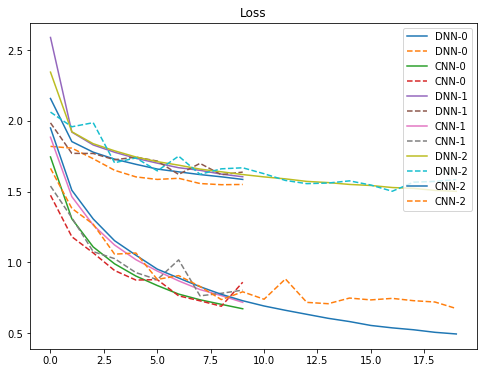

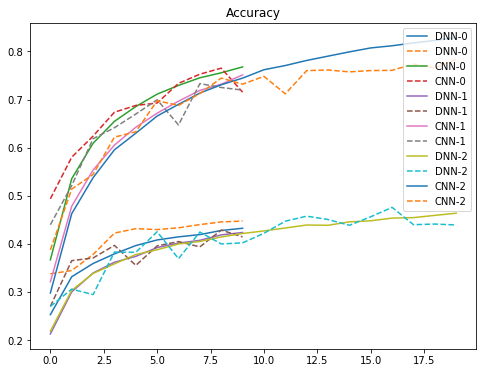

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond)
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond)
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond)
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond)
plt.title("Accuracy")
plt.legend()
plt.show()

* 1. 請試著調整各個超參數，並說明那些超參數對於結果有明顯的影響?
    * epochs越高準確率提升越明顯(前期)

* 2. CNN 與 DNN 哪個模型的參數數量比較多? 造成參數的數量不同的原因在哪?
    * DNN參數較多，CNN 有 Convolution Layer, Pooling Layer 可以減少參數數量，以及Dropout也不同